In [17]:
import h5py
%matplotlib inline
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import sys
import shutil
import glob
import optparse
import os
import json
import pandas as pd
import numpy as np
import pylab as pl
import scipy.stats as stats
import seaborn as sns
sns.set_style("ticks")
sns.set()
sns.set_color_codes()

def findOccurrences(s, ch):
    return [i for i, letter in enumerate(s) if letter == ch]

In [29]:
#hard-coding these measurements.
screen_resolution = [1920, 1080]
screen_width = 103.0 # in cm
screen_height = 58.0 # in cm
screen_distance = 30.0 # in cm

screen_height_deg = 2*np.rad2deg(np.arctan2(screen_height/2,screen_distance))
screen_width_deg = 2*np.rad2deg(np.arctan2(screen_width/2,screen_distance))


In [154]:
class struct: pass
aggregate_root = '/n/coxfs01/cechavarria/2p-aggregate/retino'

# sess_list = ['JC097_20190621','JC085_20190624','JC097_20190628','JC097_20190704','JC085_20190712']
# area = 'V1'

sess_list = ['JC080_20190619','JC091_20190621','JC091_20190628','JC097_20190702','JC091_20190703','JC085_20190704','JC097_20190708']
area = 'LM'

# sess_list = ['JC091_20190625','JC091_20190701','JC091_20190705']
# area = 'LI'

num_animals = 1
num_session = 3

filter_crit = 'ratio'
filter_thresh = .01



In [155]:
#define paths
aggregate_file_dir = os.path.join(aggregate_root,area,'files')
fig_out_dir = os.path.join(aggregate_root,area,'figures')

if not os.path.isdir(fig_out_dir):
        os.makedirs(fig_out_dir)

for sess_idx, sess in enumerate(sess_list):
#     sess_idx = 0
#     sess = sess_list[sess_idx]
    i1 = findOccurrences(sess,'_')[0]
    animalid = sess[0:i1]
    session = sess[i1+1:]


    #Set up dst paths:
    data_array_fn = '%s_retino_data_thresh_%s_%.02f.hdf5'%(sess, filter_crit, filter_thresh)
    data_array_filepath = os.path.join(aggregate_file_dir, data_array_fn)
    data_grp = h5py.File(data_array_filepath, 'r')
    stimulus_labels = data_grp.attrs['stimulus_labels']
    curr_slice = 'Slice01'

    sess_RF_ctr = np.array(data_grp['/'.join([curr_slice, 'RF_center_mean_across_files_per_condition' ])])

    sess_cell_count = np.array(data_grp['/'.join([curr_slice, 'active_cell_count_per_cond' ])])


    if sess_idx == 0:
        RF_ctr_array = sess_RF_ctr
        cell_count_array = sess_cell_count
    else:
        RF_ctr_array = np.hstack((RF_ctr_array,sess_RF_ctr))
        cell_count_array = np.vstack((cell_count_array,sess_cell_count))
        
    data_grp.close()

In [156]:
RF_x = RF_ctr_array[3,:]
RF_y = RF_ctr_array[1,:]



total_cells = RF_ctr_array.shape[1]

num_active_cells = np.sum(cell_count_array,0)
frac_active_cells = num_active_cells/float(total_cells)

num_valid_cells = np.sum(np.logical_and(np.logical_not(np.isnan(RF_x)),np.logical_not(np.isnan(RF_y))))
frac_valid_cells = num_valid_cells/float(total_cells)

print('# active cells = %i, %i'%(num_active_cells[1],num_active_cells[3]))
print('frac active cells = %.04f, %.04f'%(frac_active_cells[1],frac_active_cells[3]))

print('# valid cells = %i'%(num_valid_cells))
print('frac valid_cells = %.04f'%(frac_valid_cells))

# active cells = 259, 218
frac active cells = 0.2950, 0.2483
# valid cells = 154
frac valid_cells = 0.1754


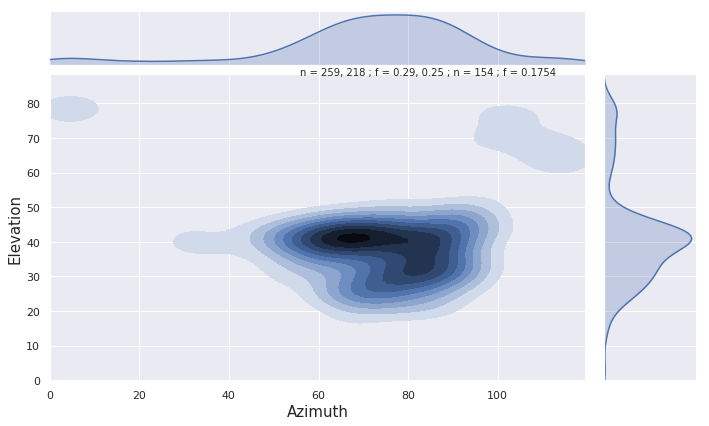

In [157]:
sns.set(style="darkgrid")
#scatter plot considers only cells with valid values for both axes
p = sns.jointplot(RF_x,RF_y,kind = 'kde',\
                   xlim = (0,screen_width_deg),ylim = (0,screen_height_deg),joint_kws=dict(shade_lowest=False))#


p.fig.set_figwidth(10.3)
p.fig.set_figheight(5.8)
xmin,xmax = p.ax_marg_x.get_xlim()
ymin,ymax = p.ax_marg_y.get_ylim()

plt.text(xmin-.15, ymax, 'n = %i, %i ; f = %.02f, %.02f ; n = %i ; f = %.04f' % \
         (num_active_cells[1],num_active_cells[3],frac_active_cells[1],frac_active_cells[3],\
          num_valid_cells,frac_valid_cells), fontsize=10)


p.set_axis_labels(xlabel='Azimuth', ylabel='Elevation',fontsize = 15)

fig_fn = '%s_%s_%s_joint_plot_kde_thresh_%s_%.02f.png'%(area, stimulus_labels[1],stimulus_labels[3]\
                                                    ,filter_crit,filter_thresh)
fig_file_path = os.path.join(fig_out_dir, fig_fn)
p.savefig(fig_file_path)
#plt.close()

In [161]:
dset_list = ['V1_JC085_20190624','V1_JC085_20190712','V1_JC097_20190621','V1_JC097_20190628',\
         'V1_JC097_20190704',\
         'LM_JC080_20190619','LM_JC091_20190621','LM_JC091_20190703','LM_JC091_20190628',\
         'LM_JC097_20190702','LM_JC097_20190708','LM_JC085_20190704',\
         'LI_JC091_20190625','LI_JC091_20190701','LI_JC091_20190705']



In [214]:
#get responses
area_list = ['V1','LM','LI']
animalid_list = []
sess_count = []
areaid = np.zeros((len(dset_list,)))
animalid = np.zeros((len(dset_list,)))
sessid = np.zeros((len(dset_list,)))

V1_count = np.array([])
V1_frac = np.array([])

LM_count = np.array([])
LM_frac = np.array([])

LI_count = np.array([])
LI_frac = np.array([])

ratio_dfs = []

for dset_idx, dset in enumerate(dset_list):
  #  dset_idx = 0
  #  dset = dset_list[dset_idx]

    #figure out some indexes
    i0 = findOccurrences(dset,'_')[0]
    i1 = findOccurrences(dset,'_')[1]

    area = dset[0:i0]
    animal = dset[i0+1:i1]
    session = dset[i1+1:]

    if animal not in animalid_list:
        animalid_list.append(animal)
        sess_count.append(0)

    sess_count[animalid_list.index(animal)] = sess_count[animalid_list.index(animal)]+1

    areaid[dset_idx] = area_list.index(area)
    animalid[dset_idx] = animalid_list.index(animal)
    sessid[dset_idx] = sess_count[animalid_list.index(animal)]-1


    #load data
    aggregate_file_dir = os.path.join(aggregate_root,area,'files')
    data_array_fn = '%s_%s_retino_data_thresh_%s_%.02f.hdf5'%(animal, session, filter_crit, filter_thresh)
    data_array_filepath = os.path.join(aggregate_file_dir, data_array_fn)
    data_grp = h5py.File(data_array_filepath, 'r')

    curr_slice = 'Slice01'

    total_cells_sess = np.sum(data_grp.attrs['s2p_cell_rois'])

    mag_ratio_array = np.array(data_grp['/'.join([curr_slice, 'mag_ratio_mean_per_file' ])])
    num_cells_sess = np.sum(np.sum(mag_ratio_array>filter_thresh,0)>0)

    frac_cells_sess = num_cells_sess/float(total_cells_sess)

    if area == 'V1':
        if V1_count.size==0:
            V1_count = num_cells_sess
            V1_frac = frac_cells_sess
        else:
            V1_count = np.vstack((V1_count, num_cells_sess))
            V1_frac = np.vstack((V1_frac, frac_cells_sess))
    elif area == 'LM':
        if LM_count.size==0:
            LM_count = num_cells_sess
            LM_frac = frac_cells_sess
        else:
            LM_count = np.vstack((LM_count, num_cells_sess))
            LM_frac = np.vstack((LM_frac, frac_cells_sess))
    elif area == 'LI':
        if LI_count.size==0:
            LI_count = num_cells_sess
            LI_frac = frac_cells_sess
        else:
            LI_count = np.vstack((LI_count, num_cells_sess))
            LI_frac = np.vstack((LI_frac, frac_cells_sess))
            

    mdf = pd.DataFrame({'animalid': animalid,
            'area': area,
            'cell_count': num_cells_sess,
            'cell_frac': frac_cells_sess,
           })

    ratio_dfs.append(mdf)
ratio_dfs = pd.concat(ratio_dfs, axis=0)


/n/coxfs01/cechavarria/envs/suite2p/lib/python3.6/site-packages/ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in greater


In [217]:
num_cells_sess

55

In [215]:
ratio_dfs

,animalid,area,cell_count,cell_frac
0,0.0,V1,89,0.640288
1,0.0,V1,89,0.640288
2,0.0,V1,89,0.640288
3,0.0,V1,89,0.640288
4,0.0,V1,89,0.640288
5,0.0,V1,89,0.640288
6,0.0,V1,89,0.640288
7,0.0,V1,89,0.640288
8,0.0,V1,89,0.640288
9,0.0,V1,89,0.640288


/n/coxfs01/cechavarria/envs/suite2p/lib/python3.6/site-packages/seaborn/categorical.py:3692: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


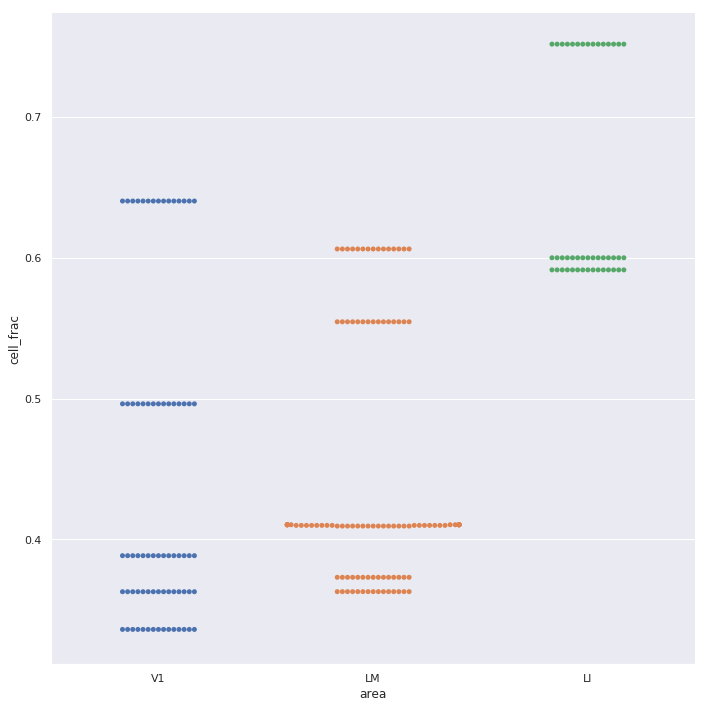

In [218]:
p = sns.catplot(x='area', y='cell_frac', kind="swarm", hue = 'area',data=ratio_dfs,size = 10);

In [199]:
V1_frac

array([89.        , 45.        , 67.        , 54.        , 40.        ,
        0.33613445])

In [203]:
V1_count = np.squeeze(V1_count)
LM_count = np.squeeze(LM_count)
LI_count = np.squeeze(LI_count)

V1_frac = np.squeeze(V1_frac)
LM_frac = np.squeeze(LM_frac)
LI_frac = np.squeeze(LI_frac)

In [204]:
print(V1_frac,LM_frac,LI_frac)

[0.64028777 0.36290323 0.4962963  0.38848921 0.33613445] [0.60625    0.36296296 0.41044776 0.40952381 0.37313433 0.55454545
 0.41      ] [0.75167785 0.6        0.59139785]


In [205]:
V1_mean = np.mean(V1_frac)
LM_mean = np.mean(LM_frac)
LI_mean = np.mean(LI_frac)


In [206]:
print(V1_mean,LM_mean,LI_mean)

0.44482219086030533 0.44669490236920945 0.6476919006037862
